In [1]:
# 🔧 Etapa 2: Pré-processamento e Feature Engineering

# 🏷️ 1. Importação e Carregamento
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Configurações visuais
pd.set_option("display.max_columns", None)
sns.set(style="whitegrid", palette="dark")

# Carregar dataset original
df = pd.read_csv("../data/datasets/students_performance.csv")
print("Shape inicial:", df.shape)
df.head()


Shape inicial: (2510, 14)


,student_id,age,gender,parental_education,study_hours_week,attendance_rate,extracurricular,sleep_hours,previous_scores,tutoring,internet_quality,family_income,health_status,final_grade
0,STD01416,22,M,bachelor,5.66,69.55,Yes,6.49,49.41,No,Good,Medium,Good,85.39
1,STD01345,19,M,bachelor,13.30,58.82,Yes,8.12,50.29,No,NaN,Medium,Good,98.43
2,STD01705,25,M,master,10.43,59.72,Yes,6.60,71.64,No,Good,Medium,Good,100.00
3,STD00299,21,F,bachelor,3.90,68.33,Yes,6.99,50.93,Yes,Poor,Low,Excellent,86.85
4,STD01762,19,F,bachelor,4.24,50.44,Yes,8.06,54.00,No,Poor,Medium,Excellent,83.25


In [2]:
# Imputação numérica com mediana
num_cols = ["study_hours_week", "attendance_rate", "sleep_hours", "previous_scores"]
num_imputer = SimpleImputer(strategy="median")
df[num_cols] = num_imputer.fit_transform(df[num_cols])

# Imputação categórica com moda
cat_cols = ["internet_quality", "family_income"]
cat_imputer = SimpleImputer(strategy="most_frequent")
df[cat_cols] = cat_imputer.fit_transform(df[cat_cols])

# Verificação final
print("Valores faltantes restantes:", df.isnull().sum().sum())


Valores faltantes restantes: 0


In [3]:
# Remover idade acima de 30 (outlier extremo)
df = df[df["age"] <= 30]

# Capping de valores extremos
df["study_hours_week"] = np.clip(df["study_hours_week"], 0, 40)
df["sleep_hours"] = np.clip(df["sleep_hours"], 4, 12)


In [4]:
# Encoding ordinal para parental_education
education_order = {"none":0, "highschool":1, "bachelor":2, "master":3, "doctorate":4}
df["parental_education"] = df["parental_education"].map(education_order)

# One-hot encoding para variáveis nominais
nominal_cols = ["gender", "extracurricular", "tutoring", "internet_quality", "family_income", "health_status"]
df = pd.get_dummies(df, columns=nominal_cols, drop_first=True)


In [5]:
scaler = StandardScaler()
scaled_cols = ["study_hours_week", "attendance_rate", "sleep_hours", "previous_scores"]
df[scaled_cols] = scaler.fit_transform(df[scaled_cols])


In [6]:
# Criar novas features
df["study_efficiency"] = df["previous_scores"] / (df["study_hours_week"] + 1)
df["sleep_quality"] = df["sleep_hours"] * df["attendance_rate"]
df["engagement_score"] = df["extracurricular_Yes"] * df["attendance_rate"]

# Visualizar
df[["study_efficiency", "sleep_quality", "engagement_score"]].describe()


,study_efficiency,sleep_quality,engagement_score
count,2509.000000,2509.000000,2509.000000
mean,1.239052,-0.021019,-0.007380
std,34.901386,1.042142,0.758505
min,-386.593149,-8.919775,-3.846373
25%,-0.609601,-0.246724,-0.086743
50%,0.004712,-0.000079,0.000000
75%,0.676955,0.228006,0.093323
max,1476.626811,8.620492,4.797807


In [7]:
# Ver variância das features numéricas
X_num = df.select_dtypes(include=[np.number]).drop("final_grade", axis=1)
variancias = pd.DataFrame({
    "feature": X_num.columns,
    "variancia": X_num.var()
}).sort_values(by="variancia")

# Remover features com variância zero
low_var_cols = variancias[variancias["variancia"] == 0]["feature"].tolist()
df.drop(columns=low_var_cols, inplace=True)

print("Features removidas por baixa variância:", low_var_cols)


Features removidas por baixa variância: []


In [8]:
X = df.drop(["student_id", "final_grade"], axis=1)
y = df["final_grade"]

# Divisão 70/15/15
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.30, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.50, random_state=42)

print("Treino:", X_train.shape)
print("Validação:", X_val.shape)
print("Teste:", X_test.shape)


Treino: (1756, 49)
Validação: (376, 49)
Teste: (377, 49)


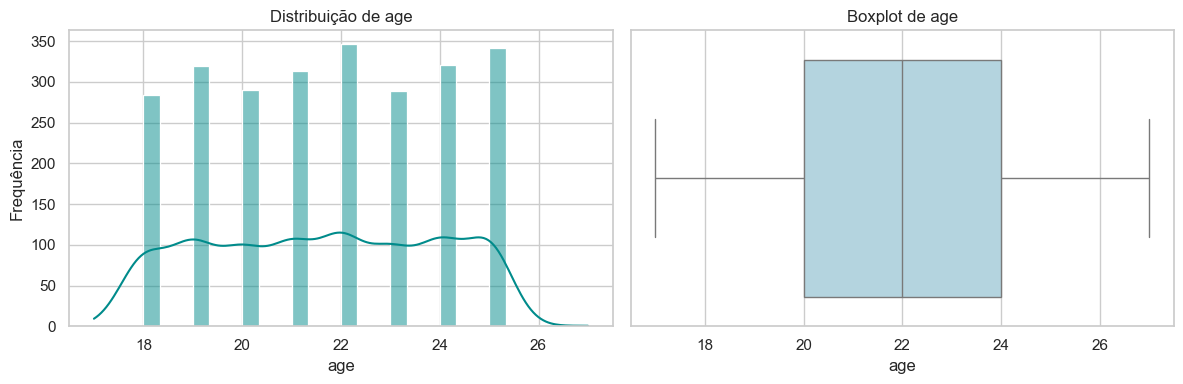

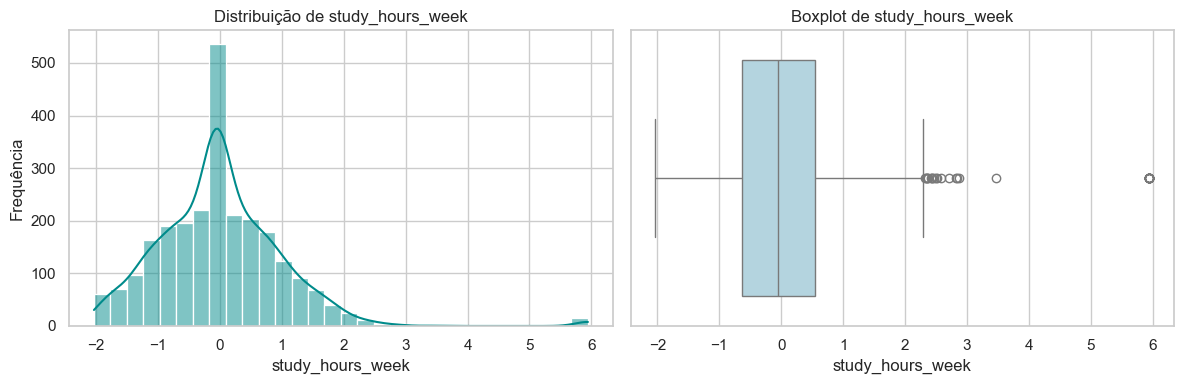

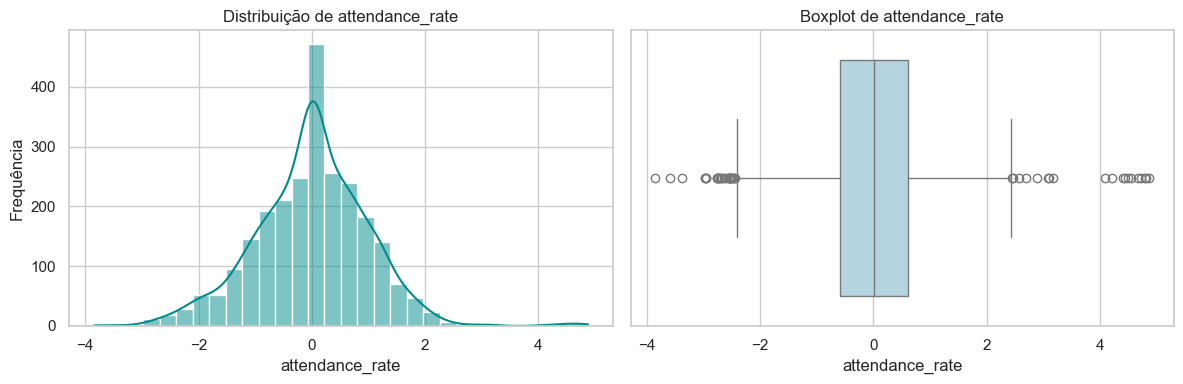

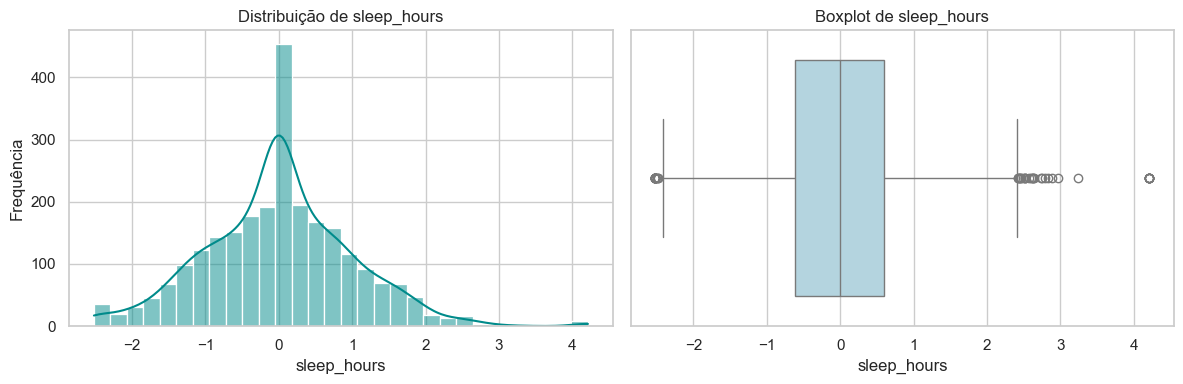

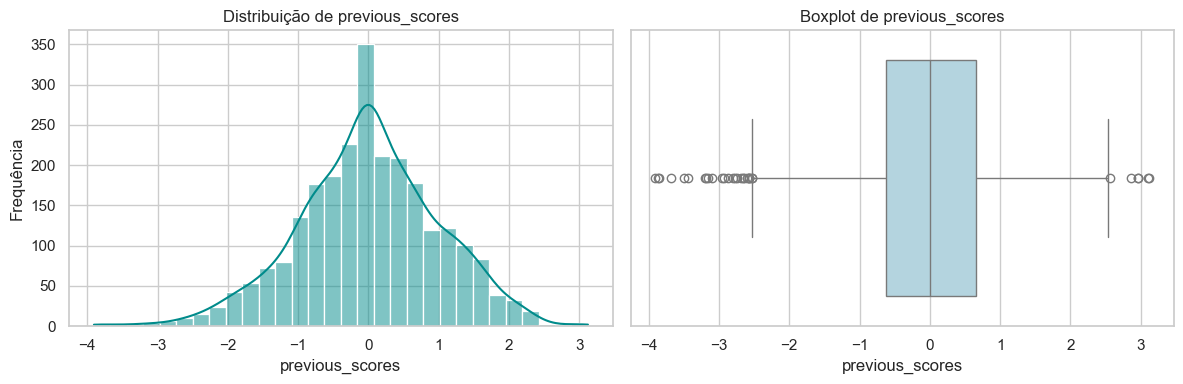

In [10]:
# Lista de variáveis numéricas tratadas
numeric_cols = ["age", "study_hours_week", "attendance_rate", "sleep_hours", "previous_scores"]

# Loop para gerar histograma + boxplot lado a lado
for col in numeric_cols:
    plt.figure(figsize=(12, 4))
    
    # Histograma com KDE
    plt.subplot(1, 2, 1)
    sns.histplot(df[col], kde=True, bins=30, color="darkcyan")
    plt.title(f"Distribuição de {col}")
    plt.xlabel(col)
    plt.ylabel("Frequência")
    
    # Boxplot
    plt.subplot(1, 2, 2)
    sns.boxplot(x=df[col], color="lightblue")
    plt.title(f"Boxplot de {col}")
    
    plt.tight_layout()
    plt.show()
